In [1]:
## Import required tools, don't need to edit.
import pandas as pd
import numpy as np
import os
import warnings
import requests

import matplotlib.pyplot as plt
from matplotlib import colors as mcolors
from matplotlib import gridspec
from matplotlib.colors import ListedColormap
import matplotlib.cm as cm
import seaborn as sns

from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, AllChem, PandasTools, rdinchi
from rdkit.ML.Descriptors import MoleculeDescriptors
from rdkit.Chem.Draw import IPythonConsole

import mordred
from mordred import Calculator, descriptors
import umap

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score, davies_bouldin_score
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE

import plotly.express as px
import molplotly

# Initialize the port for interactive plot
if 'port' not in globals():
    port = 2000

This YouTube tutorial was useful for setting up this workbook. https://www.youtube.com/watch?v=da08T-xJke0
RDKit's list of chemical descriptors is not well described in the package. You have to sort through literature to determine what each means, and many may not be interpretable. A basic guide to their descriptor list and references are here: http://www.rdkit.org/docs/GettingStartedInPython.html#list-of-available-descriptors

In [2]:
## Import data from CSV file to a Pandas Dataframe. Need to update file location. Header function prints top of table
## to quickly check data import.

folder = r'C:/Users/natha/OneDrive - Queensland University of Technology/Data and Results/Python Projects'
filename = 'TCI methacrylates and methacrylamides.xlsx'

# Read all sheets from the Excel file
all_sheets = pd.read_excel(f'{folder}/{filename}', sheet_name=None)

# Concatenate all sheets into a single DataFrame
df = pd.concat(all_sheets.values(), ignore_index=True)

print(df.info())
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 138 entries, 0 to 137
Data columns (total 3 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   My classification  138 non-null    object
 1   Monomer            138 non-null    object
 2   CAS                138 non-null    object
dtypes: object(3)
memory usage: 3.4+ KB
None


,My classification,Monomer,CAS
133,Hydrophobic,N-tert-Butylmethacrylamide,6554-73-0
134,Polar,"N,N-Dimethylmethacrylamide",6976-91-6
135,Polar,N-(Methoxymethyl)methacrylamide,3644-12-0
136,Polar,N-(Hydroxymethyl)methacrylamide,923-02-4
137,Random,3-Methacrylamidophenylboronic Acid,48150-45-4


In [3]:
%%time
def is_valid_cas(cas):
    """Basic validation for CAS number format."""
    parts = cas.split('-')
    return (len(parts) == 3 and 
            parts[0].isdigit() and 
            parts[1].isdigit() and 
            parts[2].isdigit() and 
            len(parts[2]) == 1)

def cas_to_smiles(cas):
    """Convert CAS number to its corresponding SMILES notation."""
    if not is_valid_cas(cas):
        return np.nan  # Return NaN for invalid CAS numbers
    
    url = f"https://pubchem.ncbi.nlm.nih.gov/rest/pug/compound/name/{cas}/property/IsomericSMILES/JSON"
    
    try:
        response = requests.get(url)
        response.raise_for_status() 
        data = response.json()
        
        smiles = data['PropertyTable']['Properties'][0]['IsomericSMILES']
        return smiles
    except requests.exceptions.RequestException:
        return np.nan  # Return NaN on network errors
    except (KeyError, IndexError):
        return np.nan  # Return NaN if SMILES not found

# Apply the cas_to_smiles function to the 'CAS' column and create a new 'SMILES' column
df['SMILES'] = df['CAS'].apply(cas_to_smiles)

# Count the number of NaN values in the 'SMILES' column
nan_count = df['SMILES'].isna().sum()

# Save results to Excel
output_file = os.path.join(folder, 'cas_to_smiles_results.xlsx')
df.to_excel(output_file, index=False)
print(f'{output_file} has been written to Excel')

# Display the results
print(df.info())
print(f"\nCount of NaN values in 'SMILES' column: {nan_count}")
df


KeyboardInterrupt: 

You can manually edit the Excel sheet to add any missing SMILES that weren't automatically generated. Otherwise all missing SMILES will be deleted

In [4]:
# Define saved file location and name.
output_file = os.path.join(folder, 'cas_to_smiles_results.xlsx')
print(f'Reading file: {output_file}')

Reading file: C:/Users/natha/OneDrive - Queensland University of Technology/Data and Results/Python Projects\cas_to_smiles_results.xlsx


In [24]:
## Load in Excel file above, so that you have the opportunity to manually edit SMILES if you want.
input_file=os.path.join(folder, 'cas_to_smiles_results_with_missing.xlsx')
df = pd.read_excel(input_file)

# Count the number of NaN values in the 'SMILES' column
nan_count = df['SMILES'].isna().sum()
df = df.dropna(subset=['SMILES'])
print(f"Number of NaN values in 'SMILES': {nan_count}")

# Count duplicates in the 'CAS' column
duplicate_count = df['Monomer'].duplicated().sum()
print(f"Number of duplicate 'Monomer' entries: {duplicate_count}")

df.tail()

Number of NaN values in 'SMILES': 0
Number of duplicate 'Monomer' entries: 0


,My classification,Monomer,CAS,SMILES
134,Polar,"N,N-Dimethylmethacrylamide",6976-91-6,CC(=C)C(=O)N(C)C
135,Polar,N-(Methoxymethyl)methacrylamide,3644-12-0,CC(=C)C(=O)NCOC
136,Polar,N-(Hydroxymethyl)methacrylamide,923-02-4,CC(=C)C(=O)NCO
137,Random,3-Methacrylamidophenylboronic Acid,48150-45-4,B(C1=CC(=CC=C1)NC(=O)C(=C)C)(O)O
138,Polar,n-Hydroxypropyl Methacrylate,27813-02-1,O=C(OCCCO)C(C)=C


In [25]:
# Function to create canonical SMILES from SMILES. This ensures all monomers are formatted the same, and allows for automatic
df_mon=df.copy() #creates a copy of the dataframe, so you can keep df_mon active for later use

# hydrogrenation of methacrylate alkene below.
def generate_canonical_smiles(smiles):
    mol = Chem.MolFromSmiles(smiles)  # Create a molecular object from SMILES
    if mol is not None:  # Check if the molecule was created successfully
        return Chem.MolToSmiles(mol, canonical=True)  # Generate canonical SMILES
    else:
        return None  # Return None for invalid SMILES

# Apply the function to create a new column 'Canonical_SMILES'
df_mon['Canonical_SMILES'] = df_mon['SMILES'].apply(generate_canonical_smiles)
#Drop original SMILES
df_mon.drop(columns=['SMILES'], inplace=True)
df_mon.rename(columns={'Canonical_SMILES': 'SMILES'}, inplace=True)

df_mon

,My classification,Monomer,CAS,SMILES
0,Hydrophobic,Methyl Methacrylate,80-62-6,C=C(C)C(=O)OC
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C=C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C=C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C
3,Hydrophobic,Butyl Methacrylate,97-88-1,C=C(C)C(=O)OCCCC
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C=C(C)C(=O)OCC
...,...,...,...,...
134,Polar,"N,N-Dimethylmethacrylamide",6976-91-6,C=C(C)C(=O)N(C)C
135,Polar,N-(Methoxymethyl)methacrylamide,3644-12-0,C=C(C)C(=O)NCOC
136,Polar,N-(Hydroxymethyl)methacrylamide,923-02-4,C=C(C)C(=O)NCO
137,Random,3-Methacrylamidophenylboronic Acid,48150-45-4,C=C(C)C(=O)Nc1cccc(B(O)O)c1


In [26]:
## This cell should change from (meth)acrylic monomers to hydrogenated version
df=df_mon.copy() #creates a copy of the dataframe, so you can keep df_mon active for later use

# Replace only the first occurrence of 'C=C' with 'C-C' in the 'Canonical_SMILES' column
df['SMILES'] = df['SMILES'].str.replace('C=C', 'C-C', n=1)

# Save results to Excel
output_file_2 = os.path.join(folder, 'hydrogenated monomers.xlsx')
df.to_excel(output_file_2, index=False)

df

,My classification,Monomer,CAS,SMILES
0,Hydrophobic,Methyl Methacrylate,80-62-6,C-C(C)C(=O)OC
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C-C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C-C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C
3,Hydrophobic,Butyl Methacrylate,97-88-1,C-C(C)C(=O)OCCCC
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C-C(C)C(=O)OCC
...,...,...,...,...
134,Polar,"N,N-Dimethylmethacrylamide",6976-91-6,C-C(C)C(=O)N(C)C
135,Polar,N-(Methoxymethyl)methacrylamide,3644-12-0,C-C(C)C(=O)NCOC
136,Polar,N-(Hydroxymethyl)methacrylamide,923-02-4,C-C(C)C(=O)NCO
137,Random,3-Methacrylamidophenylboronic Acid,48150-45-4,C-C(C)C(=O)Nc1cccc(B(O)O)c1


In [27]:
#Creates a molecular object from the SMILES string, including all H atoms - necessary for descriptors

mol_list=[]

for smile in df['SMILES']:
    mol = Chem.MolFromSmiles(smile)
    mol = Chem.AddHs(mol)
    mol_list.append(mol)

df_mol = pd.concat([df, pd.DataFrame(mol_list, columns = (['mol']))], axis=1)
df_mol.info()
df_mol.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   My classification  139 non-null    object
 1   Monomer            139 non-null    object
 2   CAS                139 non-null    object
 3   SMILES             139 non-null    object
 4   mol                139 non-null    object
dtypes: object(5)
memory usage: 5.6+ KB


,My classification,Monomer,CAS,SMILES,mol
0,Hydrophobic,Methyl Methacrylate,80-62-6,C-C(C)C(=O)OC,<rdkit.Chem.rdchem.Mol object at 0x0000023332D...
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C-C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x0000023332D...
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C-C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x0000023332D...
3,Hydrophobic,Butyl Methacrylate,97-88-1,C-C(C)C(=O)OCCCC,<rdkit.Chem.rdchem.Mol object at 0x0000023332D...
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C-C(C)C(=O)OCC,<rdkit.Chem.rdchem.Mol object at 0x0000023332D...


In [28]:
# Count the number of NaN values in the 'mol' column. This is a check to make sure mol file creation worked correctly. Used for debugging
nan_count = df_mol['mol'].isna().sum()

print(f"Number of NaN values in 'mol' column: {nan_count}")

# Print the 'Name' values where 'mol' is NaN
nan_names = df_mol[df_mol['mol'].isna()]['Monomer']

print("Names with NaN in 'mol' column:")
print(nan_names)

Number of NaN values in 'mol' column: 0
Names with NaN in 'mol' column:
Series([], Name: Monomer, dtype: object)


In [29]:
df_mol.tail()

,My classification,Monomer,CAS,SMILES,mol
134,Polar,"N,N-Dimethylmethacrylamide",6976-91-6,C-C(C)C(=O)N(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002332DB...
135,Polar,N-(Methoxymethyl)methacrylamide,3644-12-0,C-C(C)C(=O)NCOC,<rdkit.Chem.rdchem.Mol object at 0x000002332DB...
136,Polar,N-(Hydroxymethyl)methacrylamide,923-02-4,C-C(C)C(=O)NCO,<rdkit.Chem.rdchem.Mol object at 0x000002332DB...
137,Random,3-Methacrylamidophenylboronic Acid,48150-45-4,C-C(C)C(=O)Nc1cccc(B(O)O)c1,<rdkit.Chem.rdchem.Mol object at 0x000002332DB...
138,Polar,n-Hydroxypropyl Methacrylate,27813-02-1,C-C(C)C(=O)OCCCO,<rdkit.Chem.rdchem.Mol object at 0x000002332DB...


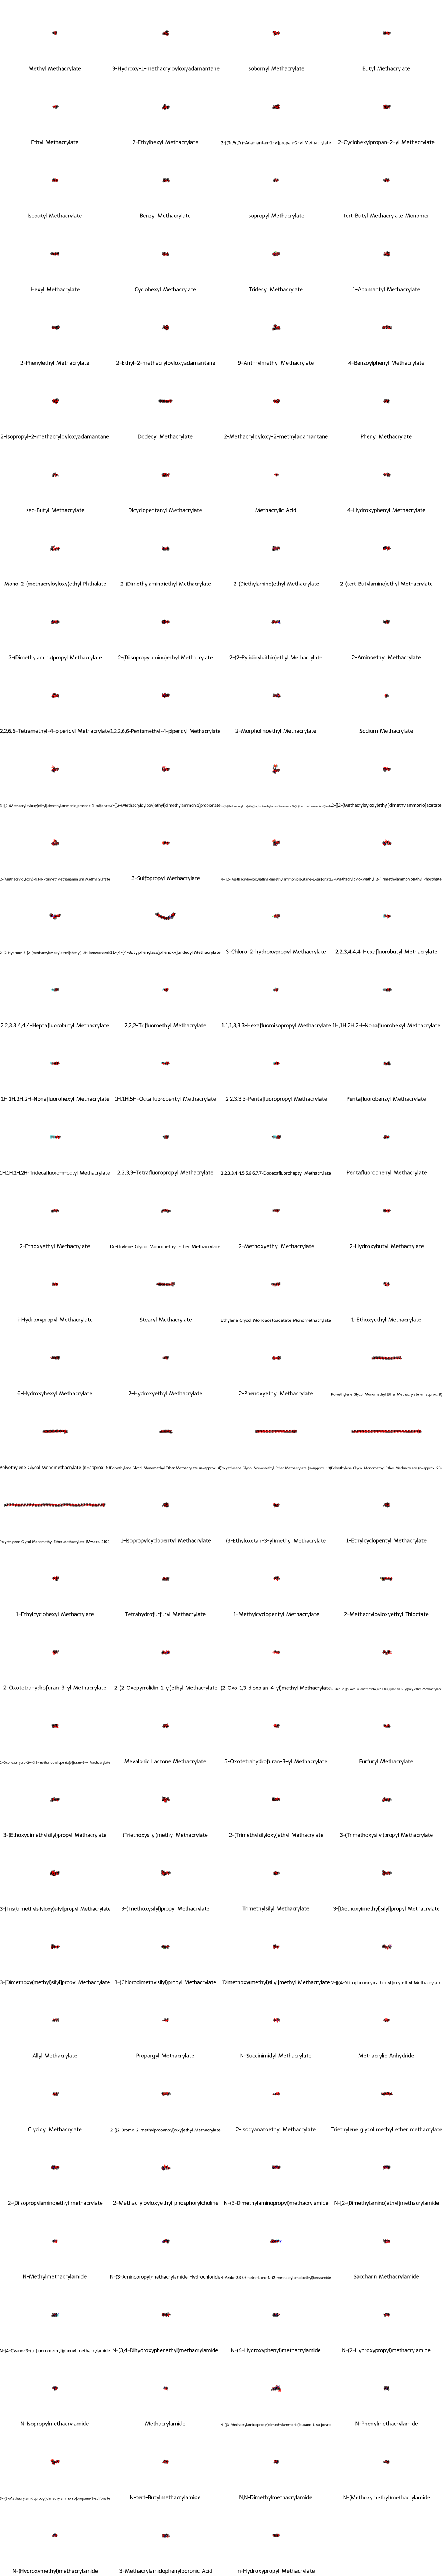

In [30]:
Draw.MolsToGridImage(df_mol['mol'],molsPerRow=4,subImgSize=(300,200),legends=[x for x in df_mol['Monomer']], maxMols=150)

## Calculate descriptors using Mordred

The YouTube tutorial: https://www.youtube.com/watch?v=EeOCGvy2pmQ&list=PL3Hxlme4R-Pa77h81Pw3jSq6-5Hj1lJ_-&index=7

The documentation: https://mordred-descriptor.github.io/documentation/master/introduction.html

In [31]:
#Creating a descriptor calculator with all 2D descriptors
calc = Calculator(descriptors, ignore_3D=True)

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\mordred\_base\calculator.py:196: DeprecationWarning:

distutils Version classes are deprecated. Use packaging.version instead.



In [32]:
# Review names and number of descriptors
all_descriptor_names = [desc.__class__.__name__ for desc in calc.descriptors]
#print(all_descriptor_names) #prints full list
print('Descriptors: ', all_descriptor_names[:20])  #prints first X number descriptors
print('Number of Descriptors: ', len(all_descriptor_names))  #prints number of descriptors

Descriptors:  ['ABCIndex', 'ABCGGIndex', 'AcidicGroupCount', 'BasicGroupCount', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AdjacencyMatrix', 'AromaticAtomsCount', 'AromaticBondsCount', 'AtomCount', 'AtomCount']
Number of Descriptors:  1613


To find explanation of all descriptors in Mordred https://mordred-descriptor.github.io/documentation/master/descriptors.html

In [33]:
#Calculate all descriptors for entire dataframe. 
all_desc = calc.pandas(df_mol['mol'])

#Create a new dataframe with monomer name, SMILES and descriptors. Drops 'mol' from df as not useful for ML.
df_mordred = pd.concat([df_mol, all_desc], axis=1)
df_mordred = df_mordred.drop(columns=['mol'])

#save an excel file
df_mordred.to_excel('20251009_Mordred_new monomers.xlsx', index=None)

# Get additional info about the DataFrame
print("\nDataFrame Info:")
print(df_mordred.info())

df_mordred.head()

 56%|█████████████████████████████████████████████▍                                   | 78/139 [00:03<00:01, 45.28it/s]

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 57%|██████████████████████████████████████████████                                   | 79/139 [00:04<00:01, 45.28it/s]

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


 59%|███████████████████████████████████████████████▊                                 | 82/139 [00:04<00:05, 10.59it/s]

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\numpy\core\fromnumeric.py:88: RuntimeWarning: overflow encountered in reduce
  return ufunc.reduce(obj, axis, dtype, out, **passkwargs)


100%|████████████████████████████████████████████████████████████████████████████████| 139/139 [00:05<00:00, 25.48it/s]



DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 139 entries, 0 to 138
Columns: 1617 entries, My classification to mZagreb2
dtypes: bool(2), float64(660), int64(320), object(635)
memory usage: 1.7+ MB
None


,My classification,Monomer,CAS,SMILES,ABC,ABCGG,nAcid,nBase,SpAbs_A,SpMax_A,...,SRW10,TSRW10,MW,AMW,WPath,WPol,Zagreb1,Zagreb2,mZagreb1,mZagreb2
0,Hydrophobic,Methyl Methacrylate,80-62-6,C-C(C)C(=O)OC,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,7.662988,2.052881,...,7.890957,32.688753,102.068080,6.004005,46,6,26.0,26.0,4.472222,1.777778
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C-C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,20.42523,2.581336,...,10.297184,51.266300,238.156895,6.106587,466,27,100.0,120.0,6.319444,3.402778
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C-C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,19.224142,2.632053,...,10.161419,66.429498,224.177630,5.604441,407,27,90.0,112.0,7.569444,3.298611
3,Hydrophobic,Butyl Methacrylate,97-88-1,C-C(C)C(=O)OCCCC,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,11.239561,2.088622,...,8.168770,37.326413,144.115030,5.542886,143,9,38.0,38.0,5.222222,2.527778
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C-C(C)C(=O)OCC,module 'numpy' has no attribute 'float'.\n`np....,module 'numpy' has no attribute 'float'.\n`np....,0,0,8.647053,2.074313,...,8.011355,34.323564,116.083730,5.804186,70,7,30.0,30.0,4.722222,2.027778


## UMAP and K-Means Analysis to cluster monomers

Creating fingerprints

hhttps://github.com/rdkit/rdkit-tutorials/blob/master/notebooks/005_Chemical_space_analysis_and_visualization.ipynb

https://corinwagen.github.io/public/blog/20230417_dimensionality_reduction.html

https://pair-code.github.io/understanding-umap/

https://github.com/wjm41/molplotly

https://jcheminf.biomedcentral.com/articles/10.1186/s13321-018-0304-9

https://www.rdkit.org/UGM/2012/Landrum_RDKit_UGM.Fingerprints.Final.pptx.pdf

In [34]:
#Creates a mol file of only the side chain, removing methacylate or methacrylamide group from consideration in 
#fingerprint generation.

df_2=df_mon.copy()
# Define your prefixes as a regex pattern
pattern = r'^(C=C\(C\)C\(=O\)O|C=C\(C\)C\(=O\)N)'

# Remove the prefix from the SMILES column
df_2['SMILES_sidechain'] = df_2['SMILES'].str.replace(pattern, '', regex=True)

mol_list = []

for smile in df_2['SMILES_sidechain']:
    mol = Chem.MolFromSmiles(smile)
    if mol is not None:
        mol = Chem.AddHs(mol)
    mol_list.append(mol)  # keep None if parsing fails

df_2['mol'] = mol_list

# Check which rows failed
failed = df_2[df_2['mol'].isna()]
print("Failed SMILES after prefix removal:")
print(failed[['SMILES', 'SMILES_sidechain']])

# Remove rows where the molecule creation failed
df_2 = df_2[df_2['mol'].notna()].copy()
df_2.head()

Failed SMILES after prefix removal:
                                 SMILES        SMILES_sidechain
123  C=C(C)C(=O)N1C(=O)c2ccccc2S1(=O)=O  1C(=O)c2ccccc2S1(=O)=O
134                    C=C(C)C(=O)N(C)C                    (C)C


[17:26:52] SMILES Parse Error: syntax error while parsing: 1C(=O)c2ccccc2S1(=O)=O
[17:26:52] SMILES Parse Error: Failed parsing SMILES '1C(=O)c2ccccc2S1(=O)=O' for input: '1C(=O)c2ccccc2S1(=O)=O'
[17:26:52] SMILES Parse Error: syntax error while parsing: (C)C
[17:26:52] SMILES Parse Error: Failed parsing SMILES '(C)C' for input: '(C)C'


,My classification,Monomer,CAS,SMILES,SMILES_sidechain,mol
0,Hydrophobic,Methyl Methacrylate,80-62-6,C=C(C)C(=O)OC,C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C=C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2,C12CC3CC(CC(O)(C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C=C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...
3,Hydrophobic,Butyl Methacrylate,97-88-1,C=C(C)C(=O)OCCCC,CCCC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C=C(C)C(=O)OCC,CC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...


In [35]:
%%time
class FP:
    """
    Molecular fingerprint class, useful to pack features in pandas df
    
    Parameters  
    ---------- 
    fp : np.array
        Features stored in numpy array
    names : list, np.array
        Names of the features
    """
    def __init__(self, fp, names):
        self.fp = fp
        self.names = names
    def __str__(self):
        return "%d bit FP" % len(self.fp)
    def __len__(self):
        return len(self.fp)

def get_cfps(mol, 
             radius=2, 
             nBits=1024, 
             useFeatures=False, 
             dtype=np.float32
            ):
    """Calculates circular (Morgan) fingerprint using the default binary fingerprint (ECFP).
    
    Parameters
    ----------
    mol : rdkit.Chem.rdchem.Mol
    radius : float 
        Fingerprint radius, default 2
    nBits : int 
        Length of hashed fingerprint (without descriptors), default 1024
    useFeatures : bool  
        To get feature fingerprints (FCFP) instead of normal ones (ECFP), defaults to False
    dtype : np.dtype
        Numpy data type for the array. Defaults to np.float32
    
    Returns
    -------
    FP
        Fingerprint (feature) object
    """
    arr = np.zeros((1,), dtype)
    # Using only GetMorganFingerprintAsBitVect for binary fingerprints
    DataStructs.ConvertToNumpyArray(AllChem.GetMorganFingerprintAsBitVect(mol, radius, nBits=nBits, useFeatures=useFeatures), arr)
    
    return FP(arr, range(nBits))

df_2['FP'] = df_2['mol'].map(get_cfps)
df_2.info()
df_2.head()

<class 'pandas.core.frame.DataFrame'>
Index: 137 entries, 0 to 138
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   My classification  137 non-null    object
 1   Monomer            137 non-null    object
 2   CAS                137 non-null    object
 3   SMILES             137 non-null    object
 4   SMILES_sidechain   137 non-null    object
 5   mol                137 non-null    object
 6   FP                 137 non-null    object
dtypes: object(7)
memory usage: 8.6+ KB
CPU times: total: 15.6 ms
Wall time: 16.2 ms


,My classification,Monomer,CAS,SMILES,SMILES_sidechain,mol,FP
0,Hydrophobic,Methyl Methacrylate,80-62-6,C=C(C)C(=O)OC,C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C=C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2,C12CC3CC(CC(O)(C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C=C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP
3,Hydrophobic,Butyl Methacrylate,97-88-1,C=C(C)C(=O)OCCCC,CCCC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C=C(C)C(=O)OCC,CC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP


In [36]:
# Select Mordred descriptors
# Adjust this list to the names of the columns in your df_mordred
selected_desc = [
    #"MW",
    "SLogP",
    "TopoPSA",
    "nN",
    "nO",
    "nRot",
    "nHBDon",
    "nHBAcc"
]

# Ensure all selected columns exist
selected_desc = [col for col in selected_desc if col in df_mordred.columns]

# Extract the columns
X_mordred = df_mordred[selected_desc]
# Keep only rows in df_mordred that exist in df_2 (align by index)
X_mordred = df_mordred.loc[df_2.index, selected_desc]

# Scale Mordred descriptors
scaler = StandardScaler()
X_mordred_scaled = scaler.fit_transform(X_mordred)

# Create new column names for the scaled descriptors
scaled_desc_names = [f"{name}_scaled" for name in selected_desc]

# Add them to df_2
df_2[scaled_desc_names] = pd.DataFrame(X_mordred_scaled, index=df_2.index)

# Check the result
df_2.head()


C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\utils\validation.py:614: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\utils\validation.py:767: FutureWarning:

is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\sklearn\utils\validation.py:605: FutureWarning

,My classification,Monomer,CAS,SMILES,SMILES_sidechain,mol,FP,SLogP_scaled,TopoPSA_scaled,nN_scaled,nO_scaled,nRot_scaled,nHBDon_scaled,nHBAcc_scaled
0,Hydrophobic,Methyl Methacrylate,80-62-6,C=C(C)C(=O)OC,C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,-0.571068,-0.422498,-0.570495,-0.275005,-0.407860,-0.501853,-0.300047
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C=C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2,C12CC3CC(CC(O)(C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,0.291155,-0.126966,-0.570495,-0.138003,-0.339467,1.135143,-0.162567
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C=C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,0.961944,-0.422498,-0.570495,-0.275005,-0.339467,-0.501853,-0.300047
3,Hydrophobic,Butyl Methacrylate,97-88-1,C=C(C)C(=O)OCCCC,CCCC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,0.122968,-0.422498,-0.570495,-0.275005,-0.202682,-0.501853,-0.300047
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C=C(C)C(=O)OCC,CC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,-0.339722,-0.422498,-0.570495,-0.275005,-0.339467,-0.501853,-0.300047


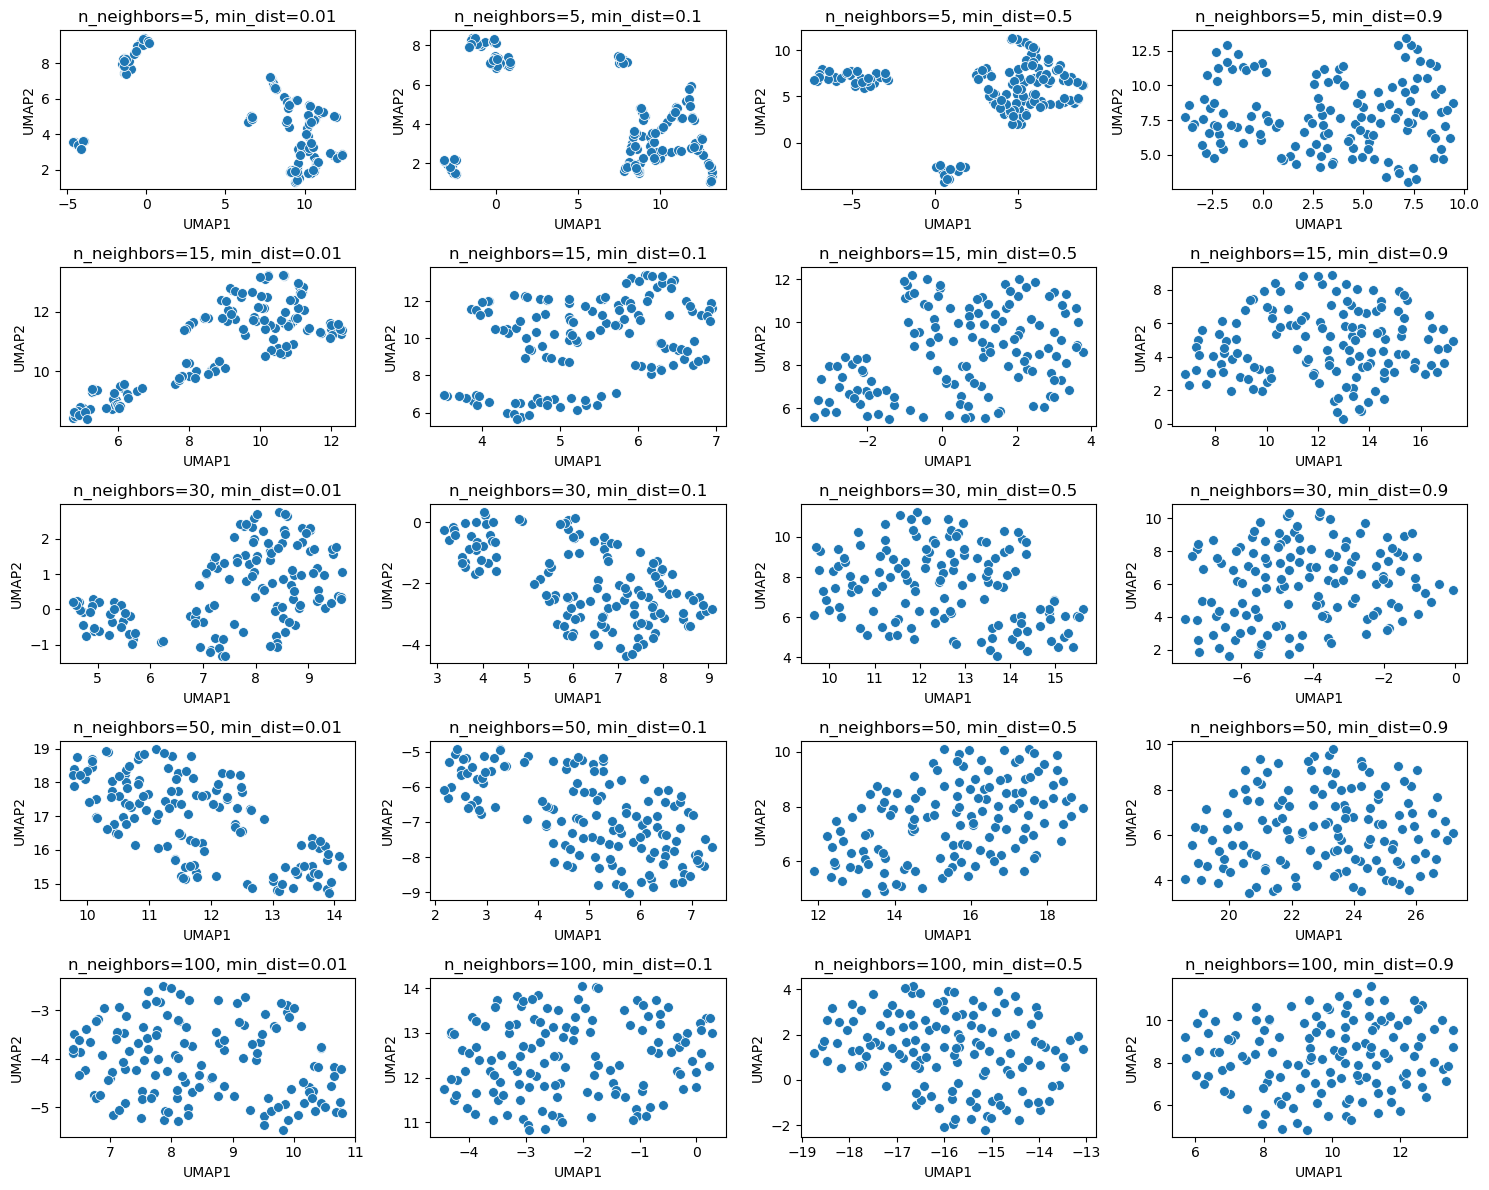

CPU times: total: 17.8 s
Wall time: 18.6 s


In [50]:
%%time
# Optional: weight descriptors relative to fingerprints
desc_weight = 2 # increase if you want descriptors to have more influence

# Build the combined feature matrix with fingerprints and scaled and weighted descriptors
X_fps = np.array([x.fp for x in df_2['FP']])
X_desc = desc_weight * df_2[scaled_desc_names].values
X_combined = np.hstack([X_fps, X_desc])

# Define the parameter grids for n_neighbors and min_dist
n_neighbors_values = [5, 15, 30, 50, 100]
min_dist_values = [0.01, 0.1, 0.5, 0.9]

# Set up a figure with subplots to visualize each combination
fig, axes = plt.subplots(len(n_neighbors_values), len(min_dist_values), figsize=(15, 12))

# Iterate through all combinations of n_neighbors and min_dist
for i, n_neighbors in enumerate(n_neighbors_values):
    for j, min_dist in enumerate(min_dist_values):
        # Create the UMAP model with the current hyperparameters
        model = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42, n_jobs=1)
        
        # Fit and transform the data
        umap_mon = model.fit_transform(X_combined)
        
        # Plot the result in the corresponding subplot
        ax = axes[i, j]
        sns.scatterplot(x=umap_mon[:, 0], y=umap_mon[:, 1], ax=ax, s=50)
        ax.set_title(f'n_neighbors={n_neighbors}, min_dist={min_dist}')
        ax.set_xlabel('UMAP1')
        ax.set_ylabel('UMAP2')

# Adjust the layout
plt.tight_layout()
plt.show()


In [52]:
"""
When you have decided on the hyperparameters for UMAP from above, you can set them here.
"""
n_neighbors = 15
min_dist = 0.01

# Reuse already-defined X_combined using fingerprints and chemical features.
model = umap.UMAP(n_components=2, n_neighbors=n_neighbors, min_dist=min_dist, random_state=42)
umap_mon = model.fit_transform(X_combined)

df_2['UMAP1'] = umap_mon[:, 0]
df_2['UMAP2'] = umap_mon[:, 1]


C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\umap\umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



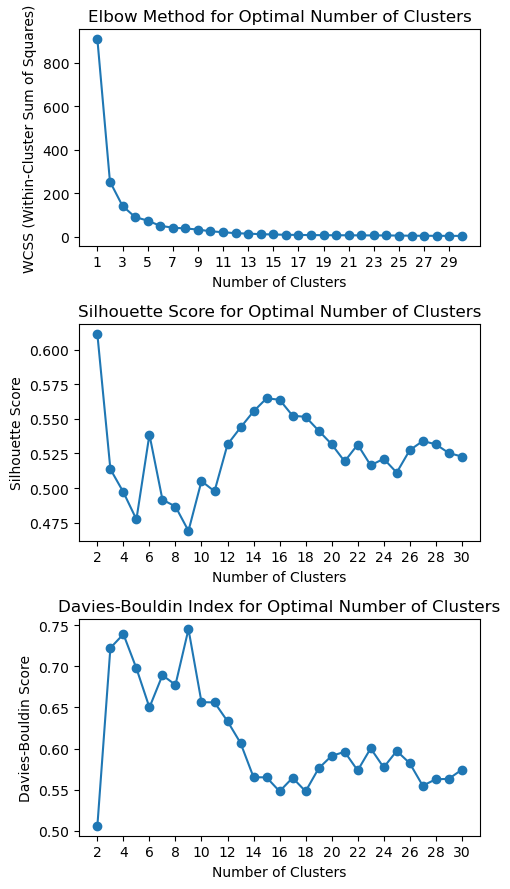

In [53]:
# KMeans throws two warnings that you can't control and doesn't affect analysis. Suppress warnings on this cell to clean up output.
warnings.filterwarnings("ignore") # Turn off warnings on notebook

# Set the range for the number of clusters
k_values = range(1, 31)

# Initialize lists to hold scores
wcss = []
silhouette_scores = []
davies_scores = []

# Calculate WCSS, silhouette scores, and Davies-Bouldin scores
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init='auto')
    cluster_labels = kmeans.fit_predict(df_2[['UMAP1', 'UMAP2']])
    
    if k > 1:  # silhouette score and davies-bouldin score require at least 2 clusters
        sil_score = silhouette_score(df_2[['UMAP1', 'UMAP2']], cluster_labels)
        db_score = davies_bouldin_score(df_2[['UMAP1', 'UMAP2']], cluster_labels)
        silhouette_scores.append(sil_score)
        davies_scores.append(db_score)
    else:
        silhouette_scores.append(np.nan)  # Add NaN for silhouette score when k=1
        davies_scores.append(np.nan)  # Add NaN for Davies-Bouldin score when k=1

    # WCSS is calculated for all k
    wcss.append(kmeans.inertia_)

# Create subplots
fig, axs = plt.subplots(3, 1, figsize=(5, 9))

# Plot WCSS
axs[0].plot(k_values, wcss, marker='o')
axs[0].set_xticks(k_values[::2])  # Set ticks every 2 clusters
axs[0].set_title('Elbow Method for Optimal Number of Clusters')
axs[0].set_xlabel('Number of Clusters')
axs[0].set_ylabel('WCSS (Within-Cluster Sum of Squares)')

# Plot silhouette scores
axs[1].plot(range(2, 31), silhouette_scores[1:], marker='o')  # Start from k=2
axs[1].set_xticks(range(2, 31, 2))  # Set ticks every 2 clusters
axs[1].set_title('Silhouette Score for Optimal Number of Clusters')
axs[1].set_xlabel('Number of Clusters')
axs[1].set_ylabel('Silhouette Score')

# Plot Davies-Bouldin scores
axs[2].plot(range(2, 31), davies_scores[1:], marker='o')  # Start from k=2
axs[2].set_xticks(range(2, 31, 2))  # Set ticks every 2 clusters
axs[2].set_title('Davies-Bouldin Index for Optimal Number of Clusters')
axs[2].set_xlabel('Number of Clusters')
axs[2].set_ylabel('Davies-Bouldin Score')

# Adjust the layout
plt.tight_layout()
plt.show()

warnings.filterwarnings("default") # Turn on warnings on notebook

Selecting the number of clusters

Pick the number of clusters where the WCSS decreases sharply and forms an "elbow" in the graph.

Silhouette score ranges from -1 to 1, where a value closer to 1 indicates that the object is well clustered, and a value closer to -1 indicates poor clustering.

Davies-Bouldin Index measures the average similarity ratio of each cluster with its most similar cluster. The lower the Davies-Bouldin index, the better the clustering solution.

Silhouette Score: 0.5682218670845032
Davies-Bouldin Score: 0.5478594147261885


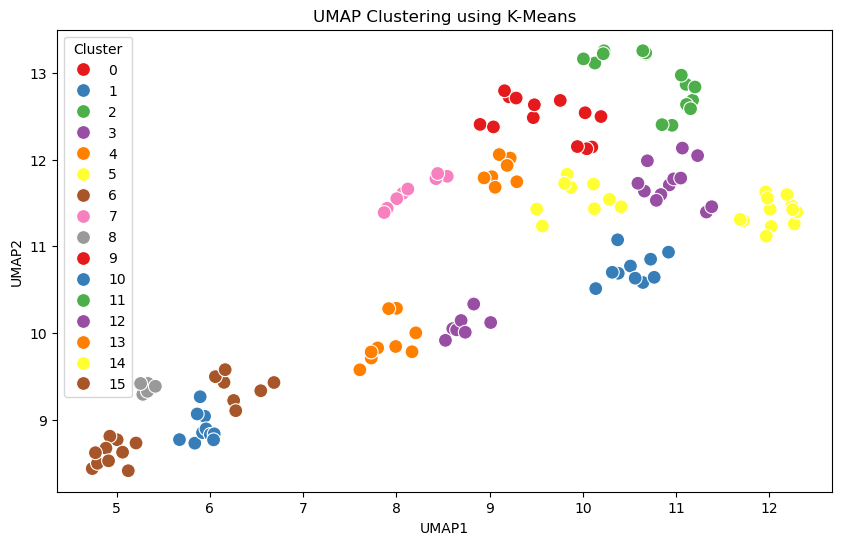

In [54]:
"""
Once you have decided on the numbr of clusters to use above, adjust n_clusters here
"""
n_clusters=16

# KMeans throws two warnings that you can't control and doesn't affect analysis. Suppress warnings on this cell to clean up output.
warnings.filterwarnings("ignore") # Turn off warnings on notebook

# Step 1: Apply K-Means on the UMAP components
kmeans = KMeans(n_clusters=n_clusters, random_state=42)  # You can adjust the number of clusters (n_clusters)
df_2['Cluster'] = kmeans.fit_predict(df_2[['UMAP1', 'UMAP2']])

# Calculate silhouette score (higher is better)
sil_score = silhouette_score(df_2[['UMAP1', 'UMAP2']], df_2['Cluster'])
print(f'Silhouette Score: {sil_score}')

# Calculate Davies-Bouldin score (lower is better)
db_score = davies_bouldin_score(df_2[['UMAP1', 'UMAP2']], df_2['Cluster'])
print(f'Davies-Bouldin Score: {db_score}')

# Step 2: Visualize the clusters
plt.figure(figsize=(10, 6))
sns.scatterplot(data=df_2, x='UMAP1', y='UMAP2', hue='Cluster', palette='Set1', s=100)
plt.title('UMAP Clustering using K-Means')
plt.show()

warnings.filterwarnings("default") # Turn on warnings on notebook

In [55]:
# Save the DataFrame to an Excel file
output_file = os.path.join(folder, 'clustered_mon_data_MFP.xlsx')
df_2.to_excel(output_file, index=False)

df_2.head()

,My classification,Monomer,CAS,SMILES,SMILES_sidechain,mol,FP,SLogP_scaled,TopoPSA_scaled,nN_scaled,nO_scaled,nRot_scaled,nHBDon_scaled,nHBAcc_scaled,UMAP1,UMAP2,Cluster
0,Hydrophobic,Methyl Methacrylate,80-62-6,C=C(C)C(=O)OC,C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,-0.571068,-0.422498,-0.570495,-0.275005,-0.407860,-0.501853,-0.300047,10.372664,11.074926,10
1,Hydrophobic,3-Hydroxy-1-methacryloyloxyadamantane,115372-36-6,C=C(C)C(=O)OC12CC3CC(CC(O)(C3)C1)C2,C12CC3CC(CC(O)(C3)C1)C2,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,0.291155,-0.126966,-0.570495,-0.138003,-0.339467,1.135143,-0.162567,5.005422,8.767378,6
2,Hydrophobic,Isobornyl Methacrylate,7534-94-3,C=C(C)C(=O)O[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,[C@@H]1C[C@H]2CC[C@]1(C)C2(C)C,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,0.961944,-0.422498,-0.570495,-0.275005,-0.339467,-0.501853,-0.300047,11.723477,11.296995,5
3,Hydrophobic,Butyl Methacrylate,97-88-1,C=C(C)C(=O)OCCCC,CCCC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,0.122968,-0.422498,-0.570495,-0.275005,-0.202682,-0.501853,-0.300047,10.096398,12.145911,9
4,Hydrophobic,Ethyl Methacrylate,97-63-2,C=C(C)C(=O)OCC,CC,<rdkit.Chem.rdchem.Mol object at 0x000002333A1...,1024 bit FP,-0.339722,-0.422498,-0.570495,-0.275005,-0.339467,-0.501853,-0.300047,10.410148,11.456457,14


In [56]:
"""
Creates an interactive plot where you can mouse over the datapoints to see what molecules are clustered
"""
# Step 2: Visualize the clusters
fig = px.scatter(df_2, x='UMAP1', y='UMAP2', color='Cluster', color_continuous_scale=px.colors.sequential.Jet_r)

# add molecules to the plotly graph - returns a Dash app
app = molplotly.add_molecules(fig=fig,
                            df=df_2,
                            smiles_col='SMILES',
                            title_col='Monomer',
                            caption_cols=['Cluster'], #caption_cols adds other columns to hoverbox, but it is a list input and has to be in square brackets.
                            show_coords=False
                            )
# run Dash app inline in notebook (or in an external server)
app.run_server(mode='inline', port=port) # If you want to run the cell again, you need to change port number or reset the kernel

# Increment port number by 1 for next run, so that it will initialize if run again.
port += 1


C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\dash\dash.py:585: UserWarning:

JupyterDash is deprecated, use Dash instead.
See https://dash.plotly.com/dash-in-jupyter for more details.

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\jupyter_dash\jupyter_app.py:310: DeprecationWarning:

setDaemon() is deprecated, set the daemon attribute instead

C:\Users\natha\.conda\envs\chemometrics\Lib\site-packages\dash\dash.py:2282: DeprecationWarning:

Dash.run_server is deprecated and will be removed in Dash 3.0

